## Review of the code provided by the professor

Imports

In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, PredefinedSplit, GroupShuffleSplit
from sklearn import preprocessing
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, Normalize
import torchvision.models as models
import timeit
import csv
import random
from collections import Counter

Set random seed for reproducibility

In [2]:
semilla=0
random.seed(semilla)
torch.manual_seed(semilla)

Set-up the GPU for its usage

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

Load meta-data and images (reduced dataset including first image only)

In [4]:
images = pd.read_pickle('/home/csanchezmoreno/tfm/data/imageset_cam1.pickle')
types = pd.read_pickle('/home/commondata/metadata.pickle')
types.reset_index(inplace=True)

Some study over the data now. First types in terms of ascending ordered datetimes values. We can see an interal of 5 mins between images.

In [5]:
types_datetimes = types[["datetimes", "types"]].sort_values("datetimes")
print(types_datetimes)
#types_datetimes.to_csv("../../data/types_vs_datetimes.csv", index=False)


              datetimes          types
270 2015-06-10 10:00:00        cumulos
271 2015-06-10 10:05:00        cumulos
272 2015-06-10 10:10:00        cumulos
273 2015-06-10 10:15:00        cumulos
274 2015-06-10 10:20:00        cumulos
..                  ...            ...
881 2015-10-16 13:35:00  estratocumulo
882 2015-10-16 13:40:00  estratocumulo
883 2015-10-16 13:45:00  estratocumulo
884 2015-10-16 13:50:00  estratocumulo
885 2015-10-16 13:55:00  estratocumulo

[1290 rows x 2 columns]


Check now how many values for each time we have: Particularly poor data over nimbostrato and cielodespejado. Additionally, as compared to [Huertas-Tato et all.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027131), we have an additional category: Aerosol. 

In [6]:
print("Original dataset counting")
print(types["types"].value_counts())

#print("\nReduced dataset counting")
#print(types[(types["types"]!="multinube") & (types["types"]!="nimboestrato") & (types["types"]!="aerosol")]["types"].value_counts())

Original dataset counting
types
multinube         263
estratocumulo     220
cirro             198
estrato           163
altocumulo        122
cirroestrato      100
cumulos           100
altoestrato        41
aerosol            33
cirrocumulo        30
cieloDespejado     14
nimboestrato        6
Name: count, dtype: int64


Check data types and shapes:

In [7]:
print(type(images))
print(type(types))
print(images.shape)

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
(3, 500, 500, 1290)


Show quick view of the attributes of interest in types dataframe and the type of the "datetimes" column

In [8]:
display(types[["datetimes", "types"]])
print(type(types[["datetimes"]].iloc[0,0]))

,datetimes,types
0,2015-08-06 10:45:00,aerosol
1,2015-08-06 10:50:00,aerosol
2,2015-08-06 10:55:00,aerosol
3,2015-08-06 12:20:00,aerosol
4,2015-08-06 12:25:00,aerosol
...,...,...
1285,2015-09-30 11:20:00,cirro
1286,2015-09-30 11:25:00,cirro
1287,2015-09-30 11:35:00,cirro
1288,2015-09-30 11:40:00,cirro


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Show one image using pyplot (we have to switch 0th and 2nd indices for this purpose) and its associated type.

In [23]:
print(images.shape)

(3, 500, 500, 1290)


In [37]:
types[(types["types"]=="estratocumulo") & (types["datetimes"].dt.date==pd.to_datetime("2015-06-15").date())]["types"].index.values

array([465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476])

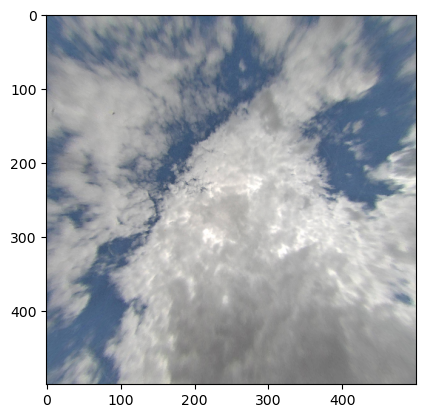

altocumulo


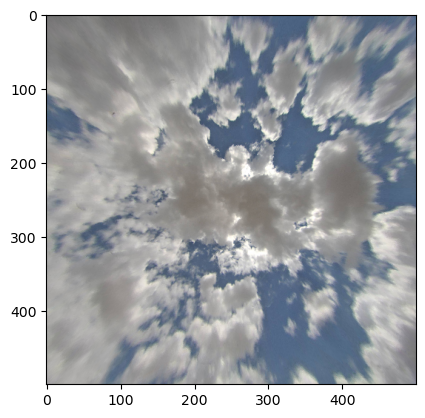

estratocumulo


In [35]:
number_image = [483, 476]
if isinstance(number_image, int):
    plt.imshow(np.moveaxis(images[:,:,:,number_image], 0, -1))
    print(types[["types"]].iloc[number_image,0])
elif isinstance(number_image, list):
    for image in number_image: # This logic doesn't work to show multiple images
        plt.imshow(np.moveaxis(images[:,:,:,image], 0, -1))
        plt.show()
        print(types[["types"]].iloc[image,0]) 
else:
    pass

We now save (uncomment) some images for the thesis report.

In [ ]:
images_to_save = [483, 476]
#for image in images_to_save:
#    img = images[:, :, :, image]              
#    img = np.transpose(img, (1, 2, 0)) # -> (H, W, 3) for matplotlib
#    img = img.astype(np.uint8)
#    plt.imsave(f"image_{image}.png", img)

Drop some kind of clouds: "aerosol", "nimboestrato" and "multinube" (they might be used later on for the test if we end up implementing some kind of uncertainty).

In [9]:
# IMPLEMENTATION 1
"""
# Gather indices of multinube, aeorosol and nimboestrato
indices_multinube = types.index[types["types"]=="multinube"].tolist()
indices_aerosol = types.index[types["types"]=="aerosol"].tolist()
indices_nimboes = types.index[types["types"]=="nimboestrato"].tolist()

# Generate selector array
selector = np.full((images.shape[-1],),True)
# Generate indices' array
indices = np.array(indices_multinube + indices_aerosol + indices_nimboes)
# Correct selector
selector[indices] = False

# Select 
images_reduced = images[...,selector]
"""

# IMPLEMENTATION 2 (easier)
# Gather indices of all pictures not being multinube, aerosol or nimboestrato. It is already returning a numpy array
indices = types[(types["types"]!="multinube") & (types["types"]!="aerosol") & (types["types"]!="nimboestrato")].index.values
#print(type(indices))

# Select images and dataframe rows 
images_reduced = images[...,indices]
types_reduced = types[(types["types"]!="multinube") & (types["types"]!="aerosol") & (types["types"]!="nimboestrato")]

In [42]:
subset = types_reduced["types"].iloc[7:15].values
subset_classes = sorted(set(subset))
subset_to_idx = {c:i for i,c in enumerate(subset_classes)}
print(subset_to_idx)

subset2 = types_reduced["types"]. iloc[285:300].values
subset2_classes = sorted(set(subset2))
subset2_to_idx = {c:i for i,c in enumerate(subset2_classes)}
print(subset2_to_idx)

{'altocumulo': 0, 'cirrocumulo': 1}
{'cieloDespejado': 0, 'cirro': 1, 'estratocumulo': 2}


And now we save this data to use it later on (uncomment it to actually save the data).

In [ ]:
import pickle

"""
with open("../data/imageset_reduced.pickle", "wb") as f:
    pickle.dump(images_reduced, f)

types_reduced.types = types_reduced.types.cat.remove_unused_categories()
with open("../data/metadata_reduced.pickle", "wb") as f:
    pickle.dump(types_reduced, f)
"""

/tmp/ipykernel_169784/327200421.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_reduced.types = types_reduced.types.cat.remove_unused_categories()


FileNotFoundError: [Errno 2] No such file or directory: '../data/metadata_reduced2.pickle'